# Continuous Control Project

I'll begin this project by implementing a straight DDPG solution and see how that works.  Depending on the amount of time it takes, I hope to follow up with additional layers of sophistication.

-----

## Solution 1 - Simple DDPG

The code below is based on the Udacity instructor-provided code from the financial markets lesson.  I have modified it somewhat to adapt to the robot arm problem for this project.

### Set up the Unity reacher environment for a single arm

In [1]:
!pip -q install ./python
print("Python install done.")

from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
print("Environment defined.")

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

ERROR: Could not find a version that satisfies the requirement tensorflow==1.7.1 (from unityagents==0.4.0) (from versions: 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.7.1 (from unityagents==0.4.0)
Python install done.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environment defined.
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
##### Set up the environment

import time
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from ddpg_agent import DdpgAgent

%matplotlib inline


In [3]:
WINNING_SCORE = 30.0 #average over 100 consecutive episodes

def train(agent, env, max_episodes=20, max_time_steps=100, break_in=32, sleeping=False):

    # Initialize simulation environment
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = len(env_info.vector_observations[0])
    action_size = brain.vector_action_space_size

    scores = []
    recent_scores = deque(maxlen=100)
    start_time = time.perf_counter()
    starting_point = 0

    # loop on episodes
    for e in range(starting_point, max_episodes):
        
        # Reset the enviroment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0 #total score for this episode

        # loop over time steps
        for i in range(max_time_steps):

            # Predict the best action for the current state.
            action = agent.act(state)

            # get the new state & reward based on this action
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            # update the agent with this new info
            agent.step(state, action, reward, next_state, done)

            # roll over new state
            state = next_state
            score += reward
            if done:
                break

        # determine epoch duration and estimate remaining time
        current_time = time.perf_counter() #was time.clock()
        avg_duration = (current_time - start_time) / (e - starting_point + 1) / 60.0 #minutes
        remaining_time_minutes = (starting_point + max_episodes - e - 1) * avg_duration
        rem_time = remaining_time_minutes / 60.0
        time_est_msg = "{:4.1f} hr rem.".format(rem_time)

        # update score bookkeeping, report status and decide if training is complete
        scores.append(score)
        recent_scores.append(score)
        avg_score = np.mean(recent_scores)
        print('\rEpisode {}\tAverage Score: {:.2f}, avg {:.1f} episodes/min'
              .format(e, avg_score, 1.0/avg_duration), end="")
        if e > 0  and  e % 50 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpointa_{:d}.pt'.format(e))
            torch.save(agent.critic_local.state_dict(), 'checkpointc_{:d}.pt'.format(e))
            print('\rEpisode {}\tAverage Score: {:.2f}\t{}             '.format(e, avg_score, time_est_msg))

        if sleeping:
            if e % 50 < 5:
                time.sleep(1) #allow time to view the Unity window

        if e > 100  and  avg_score >= WINNING_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, avg_score))
            torch.save(agent.actor_local.state_dict(), 'checkpointa.pt')
            torch.save(agent.critic_local.state_dict(), 'checkpointc.pt')
            break

    return scores

Episode 50	Average Score: 0.27	 2.2 hr rem.pisodes/min
Episode 100	Average Score: 0.39	 2.4 hr rem.pisodes/min
Episode 150	Average Score: 0.58	 2.5 hr rem.pisodes/min
Episode 200	Average Score: 0.74	 2.5 hr rem.pisodes/min
Episode 250	Average Score: 0.95	 2.3 hr rem.pisodes/min
Episode 300	Average Score: 1.16	 2.2 hr rem.pisodes/min
Episode 350	Average Score: 1.71	 2.1 hr rem.pisodes/min
Episode 400	Average Score: 2.35	 2.0 hr rem.pisodes/min
Episode 450	Average Score: 3.21	 1.8 hr rem.pisodes/min
Episode 500	Average Score: 4.34	 1.7 hr rem.pisodes/min
Episode 550	Average Score: 5.16	 1.5 hr rem.pisodes/min
Episode 600	Average Score: 6.40	 1.3 hr rem.pisodes/min
Episode 650	Average Score: 9.05	 1.2 hr rem.pisodes/min
Episode 700	Average Score: 12.36	 1.0 hr rem.pisodes/min
Episode 750	Average Score: 14.16	 0.8 hr rem.pisodes/min
Episode 800	Average Score: 14.82	 0.7 hr rem.pisodes/min
Episode 850	Average Score: 15.17	 0.5 hr rem.pisodes/min
Episode 900	Average Score: 15.15	 0.3 hr rem.

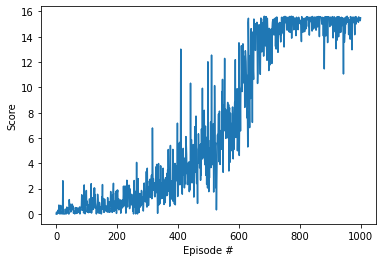

In [4]:
## Train the model & observe its progress

BATCH = 512
a = DdpgAgent(33, 4, random_seed=0, batch_size=BATCH, noise_decay=0.99999, learn_every=25)

scores = train(a, env, max_episodes=1000, max_time_steps=400, break_in=BATCH, sleeping=True)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [5]:
env.close()